## PI-GAT model and architecture

Using device: cuda
Created 80 windows.
Initializing T_PV model for continual learning...
Starting continual learning loop...

--- Processing Window 1/80 ---
Early stopping at epoch 77.

--- Processing Window 2/80 ---
Early stopping at epoch 29.

--- Processing Window 3/80 ---
Early stopping at epoch 15.

--- Processing Window 4/80 ---
Early stopping at epoch 11.

--- Processing Window 5/80 ---
Early stopping at epoch 14.

--- Processing Window 6/80 ---
Early stopping at epoch 11.

--- Processing Window 7/80 ---
Early stopping at epoch 19.

--- Processing Window 8/80 ---
Early stopping at epoch 50.

--- Processing Window 9/80 ---
Early stopping at epoch 18.

--- Processing Window 10/80 ---
Early stopping at epoch 17.

--- Processing Window 11/80 ---
Early stopping at epoch 11.

--- Processing Window 12/80 ---
Early stopping at epoch 20.

--- Processing Window 13/80 ---
Early stopping at epoch 33.

--- Processing Window 14/80 ---
Early stopping at epoch 16.

--- Processing Window 15/80 -

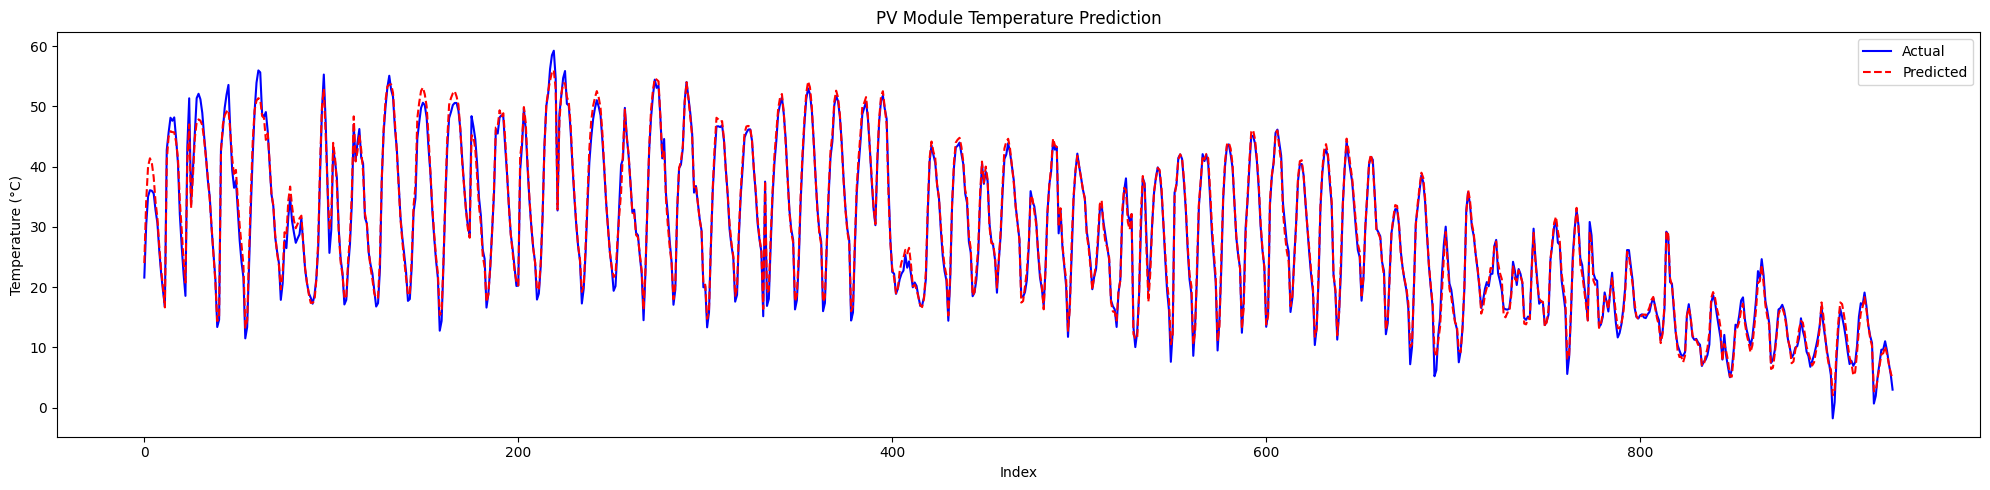

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler
import os
import random

# =====================================================
# 0. Reproducibility
# =====================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =====================================================
# 1. Data Loading & Feature Engineering
# =====================================================
target = 'T_PV'

# Load data
data = pd.read_csv("filtered_dataset_positive.csv")

# Handle h_conv
if 'h_conv' in data.columns:
    data['h_conv'] = data['h_conv'].clip(lower=0.01)
else:
    # Fallback approximation if column missing
    data['h_conv'] = 2.8 * data['U'] + 3.0 

data['date'] = pd.to_datetime(data['date'])
data['cos_incidence_angle'] = np.cos(np.radians(data['incidence angle']))

# --- REMOVED CYCLICAL TIME FEATURES ---
# We rely purely on physical inputs now.

# Define features for scaling
features = ['Glw', 'Gsw', 'T_air', 'U', 'h_conv', 'cos_incidence_angle', 'eta']

# =====================================================
# 2. Physics-Informed Graph Construction
# =====================================================
def compute_physics_edge_weights(row):
    """Thermal-specific edge weights."""
    w1 = row['Gsw'] * row['cos_incidence_angle']  # Irradiance Heating
    w2 = row['h_conv'] * row['U']                 # Convective Cooling Potential
    w3 = row['T_air']                             # Ambient Reservoir
    w4 = row['h_conv'] * np.cos(np.radians(row['eta'])) # Directional Cooling
    return [w1, w2, w3, w4]

def create_physics_graph(dataframe, features, target, scaler_X):
    num_timesteps = len(dataframe)
    edge_index = []
    edge_attr = []
    node_features = []
    
    gsw_idx = features.index('Gsw')
    gsw_mean = scaler_X.mean_[gsw_idx]
    gsw_scale = scaler_X.scale_[gsw_idx]
    scaled_50_w = (50 - gsw_mean) / (gsw_scale + 1e-6)

    for i in range(num_timesteps):
        row = dataframe.iloc[i]
        module_idx = i * 3
        env_idx = i * 3 + 1
        thermal_idx = i * 3 + 2

        # Compute 4 thermal weights
        all_physics_attrs = compute_physics_edge_weights(row)
        
        # Edges (Bidirectional)
        edge_index.extend([
            [module_idx, env_idx], [env_idx, module_idx],
            [module_idx, thermal_idx], [thermal_idx, module_idx],
            [env_idx, thermal_idx], [thermal_idx, env_idx]
        ])
        
        edge_attr.extend([all_physics_attrs] * 6)

        # --- NODE FEATURES (Reduced to 4 dimensions) ---
        
        # Module Node: Empty placeholder (model must infer T_PV)
        mod_feat = [0.0, 0.0, 0.0, 0.0] 
        
        # Environment Node: Gsw, cos, T_air, LowLight
        low_light = np.exp(-max(0, row['Gsw']) / (scaled_50_w + 1e-6))
        env_feat = [
            row['Gsw'], row['cos_incidence_angle'], row['T_air'], low_light
        ]
        
        # Thermal Node: h_conv, U, cos(eta), padding
        therm_feat = [
            row['h_conv'], row['U'], np.cos(np.radians(row['eta'])), 0.0
        ]

        node_features.extend([mod_feat, env_feat, therm_feat])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float) 
    node_features = torch.tensor(node_features, dtype=torch.float)
    target_values = torch.tensor(dataframe[target].values, dtype=torch.float)
    
    # Mask: Predict only Module Node
    mask = torch.zeros(len(node_features), dtype=torch.bool)
    mask[::3] = True

    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=target_values, mask=mask, num_timesteps=num_timesteps)

# =====================================================
# 3. Window Splitting (28/2/1)
# =====================================================
def create_window_dates(data, train_days=28, val_days=2, test_days=1):
    all_dates = sorted(data['date'].unique())
    total_window = train_days + val_days + test_days
    train_list, val_list, test_list = [], [], []

    for i in range(len(all_dates) - total_window + 1):
        train_list.append(all_dates[i : i + train_days])
        val_list.append(all_dates[i + train_days : i + train_days + val_days])
        test_list.append(all_dates[i + train_days + val_days : i + train_days + val_days + test_days])
        
    print(f"Created {len(train_list)} windows.")
    return train_list, val_list, test_list

# =====================================================
# 4. Model Architecture (Stable Tanh Version)
# =====================================================
class EnhancedPhysicsGATModel(nn.Module):
    def __init__(self, input_dim_mod, input_dim_env, input_dim_del, hidden_dim, gru_hidden_dim, dropout=0.3):
        super().__init__()
        
        self.proj_mod = nn.Linear(input_dim_mod, hidden_dim)
        self.proj_env = nn.Linear(input_dim_env, hidden_dim)
        self.proj_del = nn.Linear(input_dim_del, hidden_dim)

        # GAT layers
        self.conv1 = GATConv(hidden_dim, hidden_dim, edge_dim=4, heads=4, concat=True)
        self.conv2 = GATConv(hidden_dim * 4, hidden_dim * 2, edge_dim=4, heads=4, concat=True)
        
        gat_output_dim = hidden_dim * 2 * 4 
        self.conv3 = GATConv(gat_output_dim, gru_hidden_dim, edge_dim=4, heads=2, concat=False)
        
        self.gru = nn.GRU(gru_hidden_dim, gru_hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(gru_hidden_dim, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        num_timesteps = data.num_timesteps
        
        node_types = torch.arange(x.size(0), device=x.device) % 3 
        x_projected = torch.zeros(x.size(0), self.conv1.in_channels, device=x.device)
        
        x_projected[node_types == 0] = self.proj_mod(x[node_types == 0])
        x_projected[node_types == 1] = self.proj_env(x[node_types == 1])
        x_projected[node_types == 2] = self.proj_del(x[node_types == 2])

        # Tanh Activations for Stability
        x = F.tanh(self.conv1(x_projected, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.tanh(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.tanh(self.conv3(x, edge_index, edge_attr))

        # Correct GRU Reshaping
        gat_output_dim = x.size(1)
        x_reshaped = x.view(num_timesteps, 3, gat_output_dim)
        x_module_sequence = x_reshaped[:, 0, :] 
        x_gru_input = x_module_sequence.unsqueeze(0)
        
        x, _ = self.gru(x_gru_input) 
        x = x.squeeze(0) 
        x = self.fc(x).squeeze(-1) 
        
        return x

# =====================================================
# 5. Main Execution
# =====================================================
if __name__ == "__main__":
    
    train_date_lists, val_date_lists, test_date_lists = create_window_dates(data)

    print("Initializing T_PV model for continual learning...")
    
    # Dimensions reduced to 4 (Removed time features)
    input_dim_mod = 4  
    input_dim_env = 4  
    input_dim_del = 4  
    hidden_dim = 64
    gru_hidden_dim = 64
    
    gnn_model = EnhancedPhysicsGATModel(
        input_dim_mod, input_dim_env, input_dim_del,
        hidden_dim, gru_hidden_dim, dropout=0.3
    ).to(device)
    
    optimizer = optim.AdamW(gnn_model.parameters(), lr=0.0005, weight_decay=1e-3)
    criterion = nn.MSELoss()
    
    best_model_path = "best_temp_model_continual.pth"
    T_actual_list, T_predicted_list = [], []
    test_dates_list, test_hours_list = [], []
    
    print("Starting continual learning loop...")

    for i in range(len(train_date_lists)):
        print(f"\n--- Processing Window {i+1}/{len(train_date_lists)} ---")
        
        train_raw = data[data['date'].isin(train_date_lists[i])]
        val_raw = data[data['date'].isin(val_date_lists[i])]
        test_raw = data[data['date'].isin(test_date_lists[i])]
        
        if test_raw.empty or val_raw.empty or train_raw.empty:
            continue

        # 1. Scaling
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        scaler_X.fit(train_raw[features])
        scaler_y.fit(train_raw[[target]])
        
        def scale_df(df_raw):
            df = df_raw.copy()
            df[features] = scaler_X.transform(df_raw[features])
            df[target] = scaler_y.transform(df_raw[[target]])
            return df

        train_scaled = scale_df(train_raw)
        val_scaled = scale_df(val_raw)
        test_scaled = scale_df(test_raw)
        
        # 2. Graphs
        train_graph = create_physics_graph(train_scaled, features, target, scaler_X).to(device)
        val_graph = create_physics_graph(val_scaled, features, target, scaler_X).to(device)
        test_graph = create_physics_graph(test_scaled, features, target, scaler_X).to(device)

        # 3. Training Config (WARM-UP FIX)
        # If it's the first window, train longer to initialize weights properly
        epochs = 200 
        patience = 10

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            gnn_model.train()
            optimizer.zero_grad()
            output = gnn_model(train_graph)
            loss = criterion(output, train_graph.y)
            loss.backward()
            optimizer.step()
            
            gnn_model.eval()
            with torch.no_grad():
                val_output = gnn_model(val_graph)
                val_loss = criterion(val_output, val_graph.y)
            
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                patience_counter = 0
                torch.save(gnn_model.state_dict(), best_model_path) 
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                if i == 0 and epoch < 50: continue # Force at least 50 epochs for warm-up
                print(f"Early stopping at epoch {epoch+1}.")
                break
        
        # 4. Evaluation
        gnn_model.load_state_dict(torch.load(best_model_path)) 
        gnn_model.eval()
        
        with torch.no_grad():
            preds = gnn_model(test_graph).cpu().numpy()
            actuals = test_graph.y.cpu().numpy()

        preds_unscaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
        # Physics constraint: T_PV shouldn't be below T_air - X at night, but simple > -20 is safe
        preds_unscaled = np.maximum(preds_unscaled, -20) 
        actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

        T_actual_list.extend(actuals_unscaled.tolist())
        T_predicted_list.extend(preds_unscaled.tolist())
        test_dates_list.extend(test_raw['date'].values.tolist())
        test_hours_list.extend(test_raw['Hour'].values.tolist())

    if os.path.exists(best_model_path):
        os.remove(best_model_path)

    results_df = pd.DataFrame({
        'date': test_dates_list,
        'Hour': test_hours_list,
        'T_PV_actual': T_actual_list,
        'T_PV_predicted': T_predicted_list
    })
    
    results_df.to_csv("predictions_pv_temperature_FINAL.csv", index=False)
    
    mae = np.mean(np.abs(results_df['T_PV_actual'] - results_df['T_PV_predicted']))
    print(f"--- FINAL RESULTS (TEMP PREDICTION - PHYSICS ONLY) ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f} °C")

    plt.figure(figsize=(20, 5))
    plt.plot(results_df.index, results_df['T_PV_actual'], label='Actual', color='blue')
    plt.plot(results_df.index, results_df['T_PV_predicted'], label='Predicted', color='red', linestyle='--')
    plt.title("PV Module Temperature Prediction")
    plt.xlabel("Index")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("temp_prediction_plot.png")
    plt.show()

## Benchmarking against state of the art


MAE Results:
          Method  MAE (°C)
0    T_sapm_cell  4.592654
1  T_sapm_module  3.689338
2  T_pvsyst_cell  3.356046
3       T_faiman  3.671682
4     T_noct_sam  2.657025
5         PI-GAT  0.887309


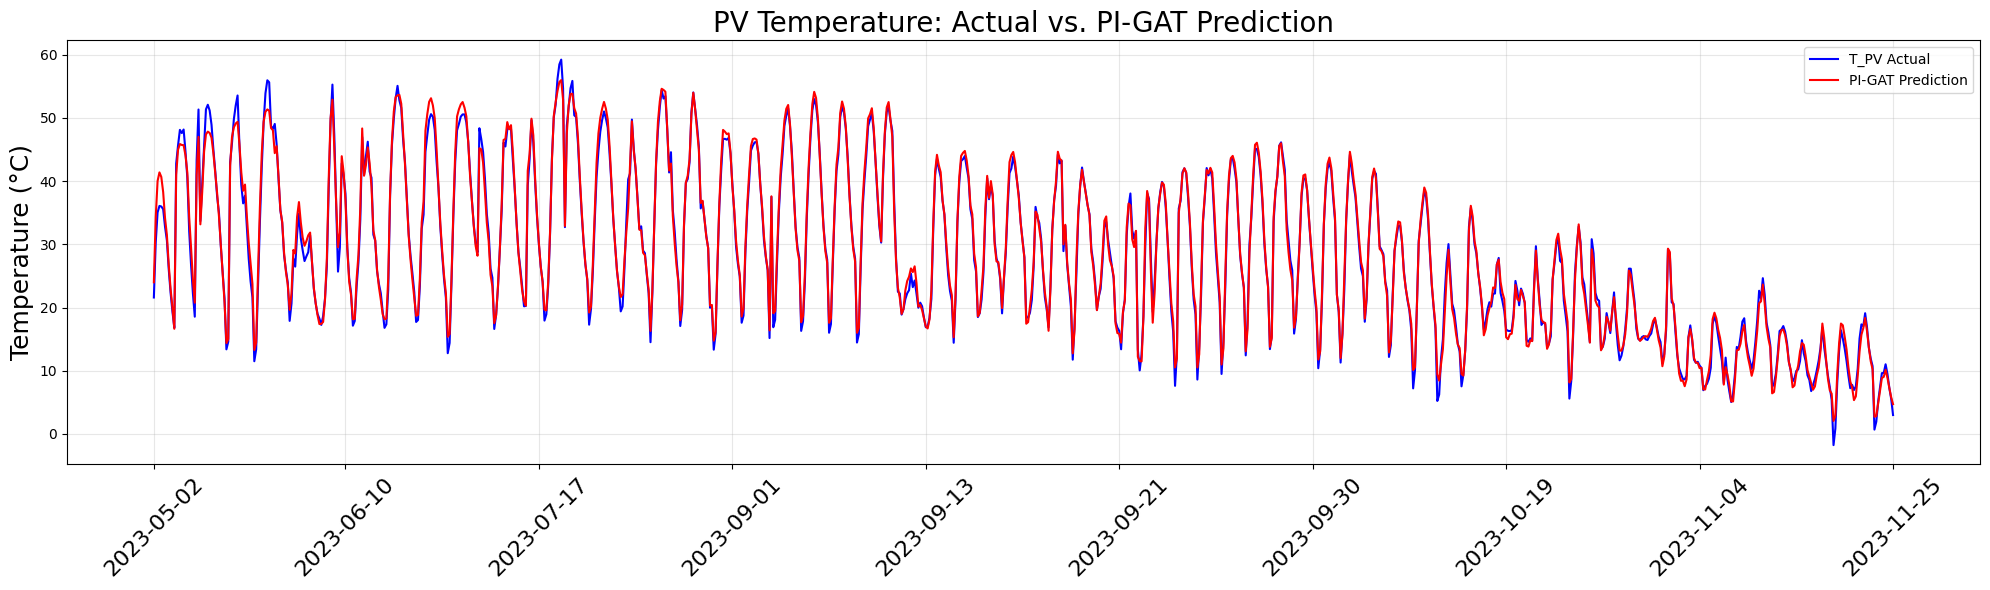

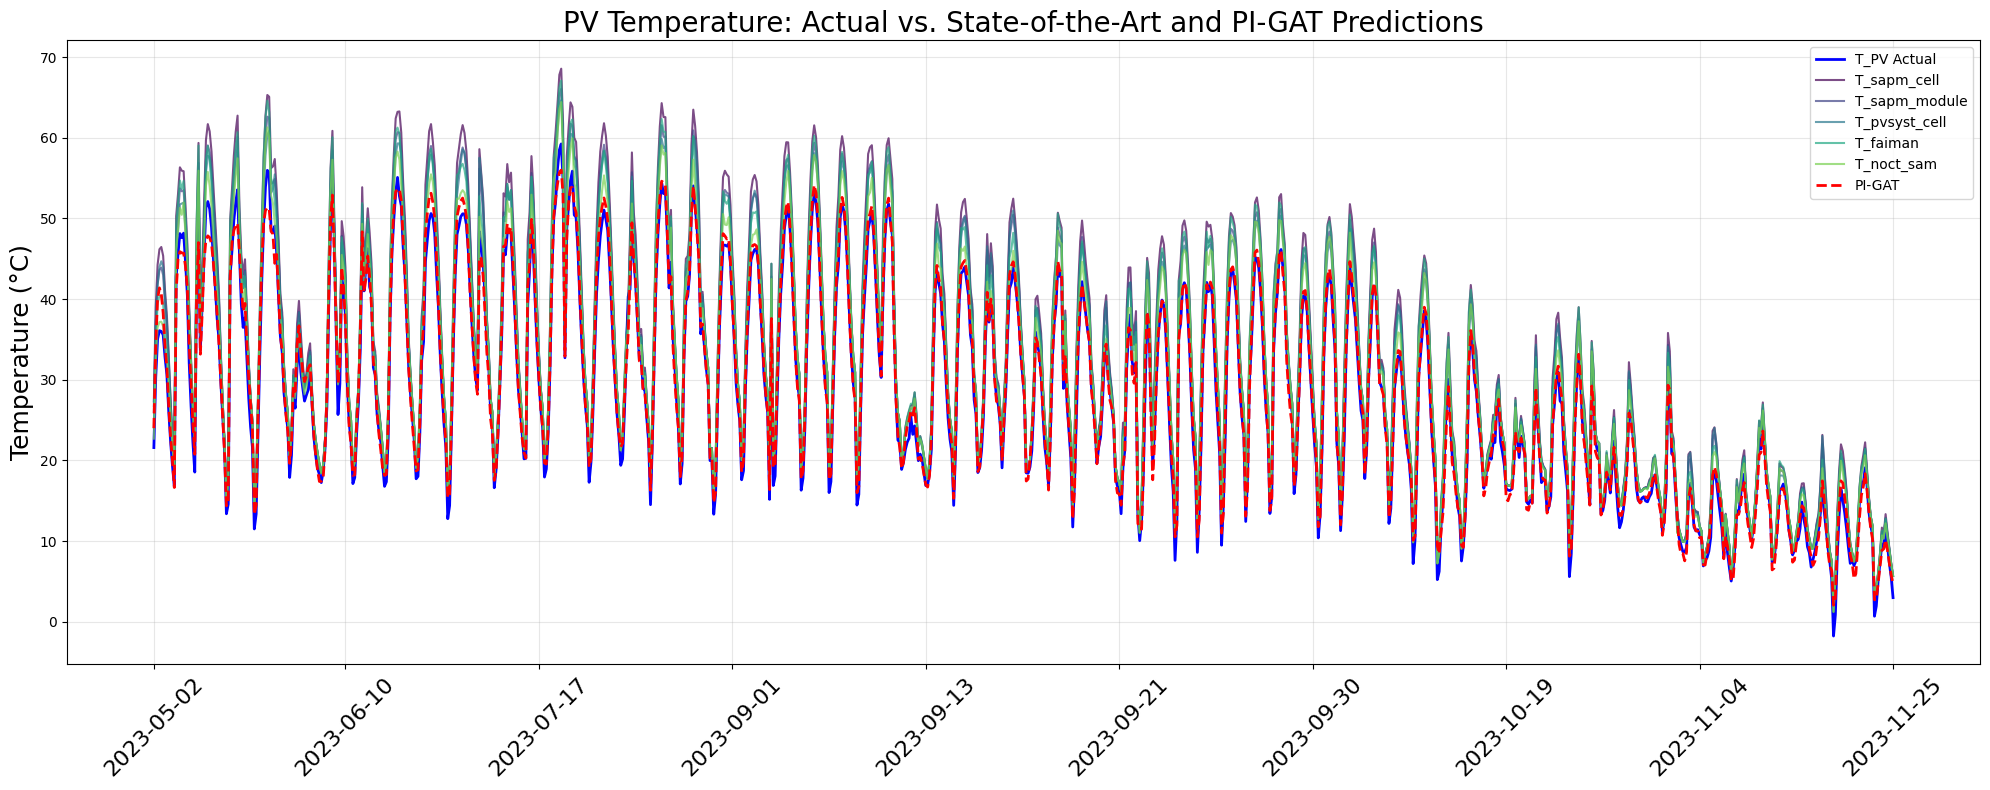

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the datasets
try:
    predictions_df = pd.read_csv("predictions_pv_temperature_FINAL.csv")
    literature_df = pd.read_csv("hourly_average_temperature(celcius)2.csv")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# --- FIX: Standardize Date Formats ---
predictions_df['date'] = pd.to_datetime(predictions_df['date'])
literature_df['date'] = pd.to_datetime(literature_df['date'])

# Ensure 'Hour' is integer type
predictions_df['Hour'] = predictions_df['Hour'].astype(int)
literature_df['Hour'] = literature_df['Hour'].astype(int)

# Merge datasets
merged_df = pd.merge(
    predictions_df[['date', 'Hour', 'T_PV_actual', 'T_PV_predicted']],
    literature_df,
    on=['date', 'Hour'],
    how='inner'
)

# Create datetime column for labeling
merged_df['datetime'] = merged_df['date'] + pd.to_timedelta(merged_df['Hour'], unit='h')
merged_df = merged_df.sort_values('datetime').reset_index(drop=True)

# Rename T_PV_predicted to "PI-GAT"
merged_df = merged_df.rename(columns={'T_PV_predicted': 'PI-GAT'})

# List of methods
methods = [
    'T_sapm_cell',
    'T_sapm_module',
    'T_pvsyst_cell',
    'T_faiman',
    'T_noct_sam',
    'PI-GAT'
]

# Calculate MAE
mae_results = {}
for method in methods:
    if method in merged_df.columns:
        mae = np.mean(np.abs(merged_df['T_PV_actual'] - merged_df[method]))
        mae_results[method] = mae

# Save MAE results
mae_df = pd.DataFrame.from_dict(mae_results, orient='index', columns=['MAE (°C)'])
mae_df = mae_df.reset_index().rename(columns={'index': 'Method'})
mae_df.to_csv("mae_literature_gnn_comparison.csv", index=False)
print("\nMAE Results:")
print(mae_df)

# --- HELPER: X-AXIS FORMATTING ---
def format_sequential_xaxis(ax, df_merged):
    # Use sequential index to avoid gaps
    num_ticks = 10
    tick_indices = np.linspace(0, len(df_merged) - 1, num_ticks, dtype=int)
    tick_labels = [df_merged.iloc[i]['datetime'].strftime('%Y-%m-%d') for i in tick_indices]
    
    ax.set_xticks(tick_indices)
    ax.set_xticklabels(tick_labels, rotation=45, size=16)
    ax.grid(True, alpha=0.3)
    ax.set_ylabel("Temperature (°C)", size=18)
    ax.legend()

x_values = merged_df.index 

# ==========================================
# PLOT 1: Actual vs PI-GAT Only
# ==========================================
plt.figure(figsize=(20, 6))

plt.plot(x_values, merged_df['T_PV_actual'], label='T_PV Actual', color='blue')
plt.plot(x_values, merged_df['PI-GAT'], label='PI-GAT Prediction', color='red')

plt.title("PV Temperature: Actual vs. PI-GAT Prediction", size=20)
format_sequential_xaxis(plt.gca(), merged_df)

plt.tight_layout()
plt.savefig("pv_temperature_actual_vs_pigat.png")
plt.show()

# ==========================================
# PLOT 2: All Methods Comparison
# ==========================================
plt.figure(figsize=(20, 8))

color_palette = plt.get_cmap('viridis', len(methods))

# Plot Actual
plt.plot(x_values, merged_df['T_PV_actual'], label='T_PV Actual', color='blue', linewidth=2)

# Plot Methods
for i, method in enumerate(methods):
    if method in merged_df.columns:
        if method == 'PI-GAT':
            # Make PI-GAT standout (red solid)
            plt.plot(x_values, merged_df[method], label=method, linestyle='--', color='red', linewidth=2)
        else:
            plt.plot(x_values, merged_df[method], label=method, color=color_palette(i), alpha=0.7)

plt.title("PV Temperature: Actual vs. State-of-the-Art and PI-GAT Predictions", size=20)
format_sequential_xaxis(plt.gca(), merged_df)

plt.tight_layout()
plt.savefig("pv_temperature_all_methods_comparison.png")
plt.show()